### Compare adjoint sensitivity against the brute force approach

In [120]:
"""
Constant-pressure, adiabatic kinetics simulation with sensitivity analysis
"""

import sys
import numpy as np
import cantera as ct

gas = ct.Solution('gri30.xml')
temp = 1200.0
pres = 20*ct.one_atm
COMP = 'CH4:0.5, O2:2, N2:7.52'

gas.TPX = temp, pres, COMP

# Get equilibrium temperature for ignition break
gas.equilibrate('HP')
T_equi = gas.T

In [121]:
import matplotlib.pyplot as plt
%matplotlib notebook
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 10
# plt.rcParams['figure.figsize'] = (8,6)

# Get the best of both ggplot and seaborn
plt.style.use('ggplot')
plt.style.use('seaborn-deep')

plt.rcParams['figure.autolayout'] = True

In [122]:
def ign_uq(factor, temp, pres):
	gas.set_multiplier(1.0) # reset all multipliers
	for i in range(gas.n_reactions):
		gas.set_multiplier(factor[i],i)
		# print(gas.reaction_equation(i)+' index_reaction:',i,'multi_factor:',factor[i])
	
	gas.TPX = temp,pres,COMP
	r = ct.IdealGasReactor(gas)
	sim = ct.ReactorNet([r])
	
	# set the tolerances for the solution and for the sensitivity coefficients
	sim.rtol = 1.0e-6
	sim.atol = 1.0e-15

	t_end = 10;
	time = []
	temp = []
	stateArray = []
	while sim.time < t_end and r.T < T_equi - 10.0:
		sim.step()
		time.append(sim.time)
		temp.append(r.T)
# 		stateArray.append(r.thermo.X)

	time = np.array(time)
	temp = np.array(temp)

# 	stateArray = np.log10(np.array(stateArray) + 1.e-300)

	diff_temp = np.diff(temp)/np.diff(time)
	
	ign_pos = np.argmax(diff_temp)
	
	# Return the log10 normal ignition delay
	ign = time[ign_pos]
	
	gas.set_multiplier(1.0) # reset all multipliers
	# plot the results if matplotlib is installed.
	# see http://matplotlib.org/ to get it
	if 0:
		import matplotlib.pyplot as plt
		%matplotlib notebook
		plt.subplot(2,2,1)
		plt.plot(states.t, states.T)
		plt.xlabel('Time (ms)')
		plt.ylabel('Temperature (K)')
		plt.subplot(2,2,2)
		plt.plot(states.t, states('OH').X)
		plt.xlabel('Time (ms)')
		plt.ylabel('OH Mole Fraction')
		plt.subplot(2,2,3)
		plt.plot(states.t, states('H').X)
		plt.xlabel('Time (ms)')
		plt.ylabel('H Mole Fraction')
		plt.subplot(2,2,4)
		plt.plot(states.t, states('CH4').X)
		plt.xlabel('Time (ms)')
		plt.ylabel('CH4 Mole Fraction')
		plt.tight_layout()
	
	return ign

In [123]:
ign0 = ign_uq(factor, temp, pres)
print("Ignition Delay is: {:.2f} ms".format(ign0*1000))

Ignition Delay is: 1.67 ms


In [124]:
import pandas as pd

In [141]:
m = gas.n_reactions

# Create a dataframe to store sensitivity-analysis data
sensitivities = pd.DataFrame(data=[], index=gas.reaction_equations(range(m)))

# Create an empty column to store the sensitivities data. 
# baseCase for brute force method
sensitivities["bruteforce"] = ""
sensitivities["adjoint"] = ""
sensitivities["ratio"] = ""

In [142]:
dk = 1.e-2
factor = np.ones( ( gas.n_reactions, 1 ) )

for i in range(m):
    factor[i] = 1+dk
    ign = ign_uq(factor, temp, pres)
    factor[i] = 1.0
    
    sensitivities["bruteforce"][i] = (ign-ign0)/(ign0*dk)
    
sensitivities.head()

(325, 3)


In [150]:
r = ct.IdealGasConstPressureReactor(gas, name='R1')
sim = ct.ReactorNet([r])

gas.TPX = temp, pres, COMP

# enable sensitivity with respect to the rates of the first 10
# reactions (reactions 0 through 9)
for i in range(m):
    r.add_sensitivity_reaction(i)

# set the tolerances for the solution and for the sensitivity coefficients
sim.rtol = 1.0e-6
sim.atol = 1.0e-15
sim.rtol_sensitivity = 1.0e-6
sim.atol_sensitivity = 1.0e-6

while sim.time < ign0:
    sim.step()

print( sim.time, ign0 )
sens_T = sim.sensitivities()[1,:]

for i in range(m):
    sensitivities["adjoint"][i] = -sens_T[i]
    sensitivities["ratio"][i] = sensitivities["bruteforce"][i] /sensitivities["adjoint"][i]

sensitivities.head(m)

0.0018832798571255204 0.0016712933807


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:25: RuntimeWarning: invalid value encountered in double_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:25: RuntimeWarning: divide by zero encountered in double_scalars


,bruteforce,adjoint,ratio
2 O + M <=> O2 + M,2.74641e-05,1.36859e-10,200674
H + O + M <=> OH + M,0.0001274,9.74993e-12,1.30668e+07
H2 + O <=> H + OH,-0.000257491,-1.32181e-10,1.94802e+06
HO2 + O <=> O2 + OH,0.00403873,4.8159e-10,8.38624e+06
H2O2 + O <=> HO2 + OH,0.000272363,7.12462e-12,3.82284e+07
CH + O <=> CO + H,-0.000216782,5.65463e-16,-3.83371e+11
CH2 + O <=> H + HCO,9.12585e-05,-3.20613e-16,-2.84638e+11
CH2(S) + O <=> CO + H2,-0.000172072,6.18064e-16,-2.78405e+11
CH2(S) + O <=> H + HCO,-7.53204e-05,2.07032e-16,-3.63811e+11
CH3 + O <=> CH2O + H,0.00132338,-5.94123e-16,-2.22746e+12


<IPython.core.display.Javascript object>


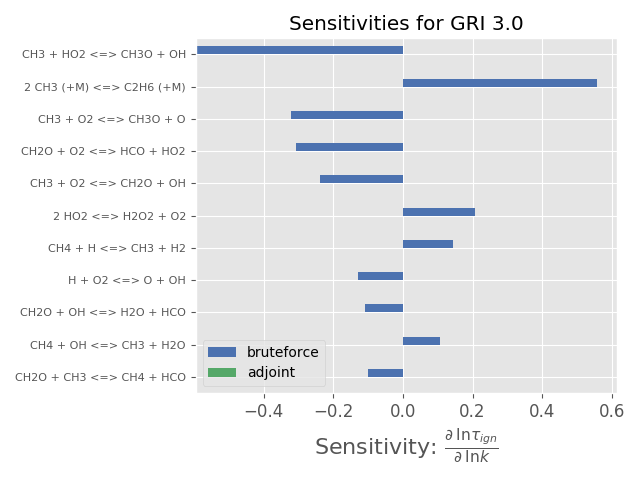

,bruteforce,adjoint,ratio
CH3 + HO2 <=> CH3O + OH,-0.595083,-6.95742e-16,8.55321e+14
2 CH3 (+M) <=> C2H6 (+M),0.558446,4.84055e-27,1.15368e+26
CH3 + O2 <=> CH3O + O,-0.321215,-6.91026e-16,4.64838e+14
CH2O + O2 <=> HCO + HO2,-0.306162,3.5244e-16,-8.68691e+14
CH3 + O2 <=> CH2O + OH,-0.237878,-5.52404e-16,4.30623e+14
2 HO2 <=> H2O2 + O2,0.206175,7.97738e-12,2.5845e+10
CH4 + H <=> CH3 + H2,0.143473,-7.89137e-18,-1.8181e+16
H + O2 <=> O + OH,-0.12945,6.39576e-09,-2.02399e+07
CH2O + OH <=> H2O + HCO,-0.109567,-1.25189e-16,8.75211e+14
CH4 + OH <=> CH3 + H2O,0.107419,-1.0167e-17,-1.05654e+16


In [151]:
# Reaction mechanisms can contains thousands of elementary steps. Choose a threshold
# to see only the top few
threshold = 1e-1

firstColumn = sensitivities.columns[0]

# For plotting, collect only those steps that are above the threshold
# Otherwise, the y-axis gets crowded and illegible
plt.rcParams.update({'ytick.labelsize': 8})

sensitivitiesSubset = sensitivities[sensitivities[firstColumn].abs() > threshold]
indicesMeetingThreshold = sensitivitiesSubset[firstColumn].abs().sort_values(ascending=False).index
sensitivitiesSubset[sensitivities.columns[0:2]].loc[indicesMeetingThreshold].plot.barh(title="Sensitivities for GRI 3.0",
                                                          legend=[True])
plt.gca().invert_yaxis()
plt.rcParams.update({'axes.labelsize': 16})
plt.xlabel(r'Sensitivity: $\frac{\partial\:\ln{\tau_{ign}}}{\partial\:\ln{k}}$');

sensitivitiesSubset.loc[indicesMeetingThreshold]


# It seems that the adjoint method failed. Perhaps something wrong with the derivation, or due to the poorly definition of ignition delay time.